### Update 03.08.2021

#### Plan for tomorrow

Continue write up, think I need to explain where predicitons and loss are stored. Might need to review chapter again at some point.

### Update 02.08.2021

Sources:

- [Kaggle writeup](https://www.kaggle.com/aakashkhadka/mnist-pytorch)
- [PyTorch MNIST Fashion tutorial - Datasets / dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
- [PyTorch MNIST source code](https://pytorch.org/vision/stable/_modules/torchvision/datasets/mnist.html#MNIST)
- [PyTorch overview - creating data models](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)

#### Plan for tomorrow

Examine sources above, make notes, think about how to structure this notebook and the writeup


### Update 30.07.2021

This version appears to offer the most accurate model so I'll use this as the basis for my blog post.


### Update 28.07.2021

The files structure is quite messed up here. I'm going to label each of these to make writing up easier. This file is:

- external solution using PyTorch and MNIST CSV file
- [source](https://www.kaggle.com/aakashkhadka/mnist-pytorch)


**Goals**

- Reconfiguring my colab project for fastai Chapter 4. 
- Extending project with PyTorch and fastai features

**Update 01.06.2021**

I think the key to completing this project (my own code in fact) is to find a way to integrate PyTorch into it. If I just follow the example but adapt it to my own purpose I think I might just be able to train this model.

**Update 31.05.2021** 

Not made much progress today, but I do think it's worth checking out the PyTorch documentation on DataLoaders and Datasets as I think these make it much clearer what the code is doing compared to the Kaggle doc: [link](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

**Update 26.05.2021**

I think for my next post I'll discuss how H&G's solution compares to the one I found on Kaggle. From there I can still work on coding up my own bespoke code but at least it gives me a solution to the original blog premise.


**Update 19.05.2021**

- The model works now, I had just missed out a section. I'm still not sure why it works or for that matter what it's doing, but at least the code is running locally

*Next steps*

- Compare this code to my previous material and that of H&G. Perhaps this might help me work it out and also enable me to finally complete this project.

**Update 18.05.2021**

- Defining training and testing data sets before the class definition seems to have created an issue
- There appears to be an issue where the data is not being passed to the GPU

**Update 13.05.2021**

This [Kaggle Project](https://www.kaggle.com/aakashkhadka/mnist-pytorch) appears to have a solution using PyTorch. I will adjust this writeup to incorporate the solution here.

#### Notes

- Could remove the exploritory stuff since this has already been covered in the last blog post.

## Blog notes

In my last update, I was unable to train a model capable of recognising handwritten digits. The reason for this was mainly due to my inability to structure the data (a CSV file based on MNIST database) in such a manner that the mathematical operation necessary to train a model could be performed on it (see below for more details).

While I have still have not been able to code up a solution to this problem myself for an update I decided to compare some approaches to this problem. To begin with, we have Howard and Guggen's partial solution (which is only capable of distinguishing 3s and 7s) that uses a different approach where direct greyscale labeled images are used and this project from Kaggle (which I have amended slightly) that uses the same CSV data I have but that trains the model with some features from PyTorch.

My intention with this post then is to examine these code bases and highlight some features I think that are useful in terms of training a model to recognisne digits. I may at some point update this post again if I can apply these techniques to my own code directly.

In [5]:
# Libraries required for data analysis and visualisation

import pandas as pd
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt    

# Dataset and DataLoader are of particular importance as these will 
# structure the data such that the necessary mathematically operations
# required to generate a model can be applied to the data.

# For more details review: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
 

from torch.utils.data import Dataset,DataLoader

In [6]:
# MNIST data containing number label and values for pixel hue in a
# 28x28 grid

training_data = open('mnist_train.csv')



In [7]:
# DataFrame based on training data

training_data_df = pd.read_csv(training_data)

In [8]:
# Sample of DateFrame values. Includes label and pixel hue values

training_data_df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# Creating an MNIST Dataset that outputs an array consisting of the 
# number label and pixel hues for that number. ToTensor converst this
# array to a tensor that can be used for processing by the GPU.



class MNIST_Dataset(Dataset):
    def __init__(self, path, transform=None):
        # Create a DataFrame based on MNIST CSV file
        num_pix_df = pd.read_csv(path)
        # Series of number labels
        self.num_labels = num_pix_df['label']
        # DF for all pixel values
        self.pix_vals = num_pix_df.iloc[:,1:].values # Review how this works in more detail
        # Hue value of pixel from integer images
        self.n_samples = len(num_pix_df)
        self.transform = transform
        
    def __getitem__(self, index):
        #Tuple pixel values and np array of number labels 
        sample = self.pix_vals[index],np.array(self.num_labels[index]) 
        if self.transform is not None:
            sample = self.transform(sample)
        return sample
    
    def __len__(self):
        return self.n_samples
    
# Converts arrays to tensors

class ToTensor:
    def __call__(self, sample):
        inputs, target=sample
        return torch.from_numpy(inputs), torch.from_numpy(target)

In [29]:
# Creating Training and Testing sets from my locally stored MNIST csv
# files using the MNIST class created above

training_path = open('mnist_train.csv')
testing_path = open('mnist_test.csv')

training_set = MNIST_Dataset(training_path, transform = ToTensor())
testing_set = MNIST_Dataset(testing_path)



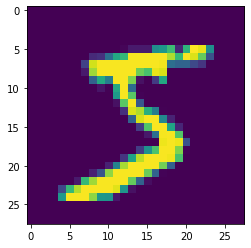

In [31]:
# Here is a visual example of number from the data set

example = training_set[0]
plt.imshow(example[0].numpy().reshape(28,28))

In [32]:
# Using PyTorch's in-built DataLoader function to structure batches for
# training and testing data sets. Dividing the data in this way 
# improves GPU performance

from torchvision import transforms

training_loader=DataLoader(training_set,batch_size=100,shuffle=True)
testing_loader=DataLoader(testing_set,batch_size=100,shuffle=True)



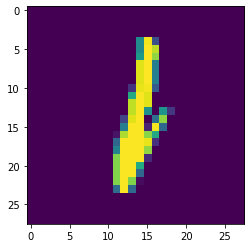

In [36]:
# Another visual example, this time a sample from the batch. Since
# the data is shuffle it should adjust each time this command is run.

plt.imshow(iter(training_loader).next()[0][0].reshape(28,28))

In [37]:
iter(training_loader).next()[0][0].dtype



torch.int64

In [15]:
# Next we generate a neural net to perform the matrix operations on the
# data. First some presets must be configured


# we set this to 1 because the hues are greyscale image
input_size=1
# first convolution converts 1 channel to 16 channels in feature maps
hid1_size=16
# then to 32 channels
hid2_size=32

k_conv_size=5
import torch.nn.functional as F

In [16]:
# Class that defines the neutral net. This has two layers and the 
# forward function defines the process between the two layers to 
# progressively improve the prediction

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1=torch.nn.Sequential(
        torch.nn.Conv2d(input_size,hid1_size,k_conv_size),
        torch.nn.BatchNorm2d(hid1_size),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2)
            
        )
        
        self.layer2=torch.nn.Sequential(
            torch.nn.Conv2d(hid1_size,hid2_size,k_conv_size),
            torch.nn.BatchNorm2d(hid2_size),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )
        self.fc=torch.nn.Linear(512,10)
        
        
    def forward(self,x):
        x=self.layer1(x)
        
        x=self.layer2(x)
        # Changing the image into one dimensional tensor for feeding 
        # the fully connected layers
        x=x.reshape(x.shape[0],-1)
       
        x=self.fc(x)
        return x

In [17]:
# Generating the neural net from the GPU you - must be an NVIDIA model

model=Net()
device=torch.device('cuda')
model.to(device)

Net(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [38]:
# Next we generate the loss function, in this case a Cross Entropy Loss

lr=1e-3
loss_fn=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=lr,momentum=0.9)

In [20]:
# Setting the number of epochs for the model to run

epochs=3
loss_values=[]

In [21]:
# Here the pixel hues are converted back to images. I wonder if there
# would be a more direct way to analyse the images?


targets=np.array([])
preds=np.array([])
for epoch in range(epochs):
    for i,(img,target) in enumerate(training_loader):
        img=img.reshape(100,1,28,28).float().to(device)
        optimizer.zero_grad()
        output=model(img)
        pred=torch.argmax(output,axis=1)
#         print(target,pred)
        targets=np.hstack([targets,target.cpu().numpy()])
        preds=np.hstack([preds,pred.cpu().numpy()])
        loss=loss_fn(output,target.to(device))
        
        loss.backward()
        optimizer.step()
        if i % 100==0:
            print(loss)

tensor(2.6321, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5504, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2624, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2095, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2140, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1542, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1304, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1838, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1246, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1617, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1232, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0821, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1307, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1306, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0744, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1786, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1781, device='cuda:0', grad_fn=<NllLossBackward

In [20]:
from sklearn.metrics import accuracy_score,recall_score

In [21]:
accuracy_score(targets,preds)

0.9506388888888889

In [22]:
recall_score(targets,preds,average='macro')

0.950270950220083